# Imports

In [16]:
import pandas as pd
import numpy as np
import os
import json
import sys
sys.path.append("..")

import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from src.preprocessing import clean_tweet_for_transformers
from src.utils import read_data
from src.utils import evaluate_model, compute_metrics
from src.utils import set_seed
#set_seed(20042022)

from transformers import TFAutoModel,AutoTokenizer

## Load results.csv

## Metrics

The metrics used to assess this task are some of the most commonly used to evaluate binary classification problems: <br />
- **Accuracy**: Accuracy measures the ratio of correctly predicted observation to the total observations. <br />
-**F1 score**:F1 Score is the weighted average of Precision and Recall. It is usually more useful than accuracy, especially with unbalanced class distribution, like in our case. <br />
-**Precision**: Precision is the fraction of positive instances among all retrieved instances <br />
-**Recall**: Recall is defined as the fraction of retrieved instances among all relevant instances from the positive class. <br />

It is worth remembering that our dataset is unbalanced, therefore is it advisable to favour f1 score rather than acuracy when selecting the best model architecture.

In [8]:
import pandas as pd

df = pd.read_csv('../trained_models/results.csv')

The following tables shows the metrics obtained for the tested model architectures and the model runtime (trained with GPU).The training time grows significatively when fine-tuning transformers architecture to suit this tasks, but the models provide better results for this problem.  <br />

For the neural networks models, three different architectures were trained, exploring simple CNN, LSTM and GRU models. These models have been trained both normally and with class weights to smoothing the unbalanced data. Among these three models, the best resulting model, namely the GRU architecture, is then used to explore transfer learning with fastText pretrained embeddings too, applying 2 different preprocessing functions. <br />

In [9]:
df_networks = df.iloc[:10,:]
df_networks

,model,accuracy,f1_score,precision,recall,runtime
0,cnn_baseline,0.833818,0.595493,0.696805,0.519901,20.736634
1,cnn_classWeights,0.805936,0.627312,0.572196,0.694176,17.270849
2,lstm_baseline,0.839903,0.655117,0.664202,0.646278,17.070774
3,lstm_classWeights,0.802550,0.647326,0.558272,0.770182,16.892578
4,gru_baseline,0.845246,0.630822,0.718930,0.561952,15.963573
5,gru_classWeights,0.822708,0.661481,0.600514,0.736227,15.741524
6,gru_fastText_hardPreproc,0.841384,0.620218,0.710183,0.550483,19.237489
7,gru_fastText_hardPreproc_classWeights,0.819480,0.648175,0.598553,0.706769,19.731280
8,gru_fastText_softPreproc,0.846146,0.651820,0.697055,0.612098,25.665023
9,gru_fastText_softPreproc_classWeights,0.815830,0.662530,0.582311,0.768383,25.987306


In [10]:
df_transformers = df.iloc[10:,:]
df_transformers

,model,accuracy,f1_score,precision,recall,runtime
10,bert_cased,0.866864,0.711833,0.726636,0.697622,446.224822
11,bert_cased_classWeigths,0.856395,0.715364,0.671322,0.765590,508.995694
12,bert_uncased,0.869032,0.717011,0.730617,0.703903,508.290840
13,bert_uncased_classWeigths,0.850949,0.719976,0.646104,0.812921,385.988626
14,bertweet,0.870777,0.738554,0.705930,0.774338,514.048379
15,bertweet_classWeigths,0.851742,0.725206,0.643926,0.829969,515.918136


In the second table the results for the transformers model are displayed. BERT fine-tuning is explored both from its cased and uncased version; additionally the BERTweet transformers is also tested. All experiments come both in normal and class weigtht training and show that the introduction of class weights is useful to better detect 'clickbait' tweets, at the cost of a reasonable loss in the evaluation metrics. <br />

Two different preprocessing functions were used to better clean the text of tweets, suiting the needs of the different architectures (deeper for simple neural networks, softer for transformers). This choice has been taken since for transformers the preprocessing seems to impact less on the performances of the models, due to different motivations. For instance, BERT models uses BPE in the encoding and it can handle the input sequences even though lemmatization or stemming are not applied. <br />


## Model comparison

From the results obtained with these experiments, we can observe that the trasnformer models fine-tuned for this task performs better than the CNNs, LSTMs and GRUs networks that have been tested. Most of the times, we can see that with the class weight option helps the models to better capture the 'true clickbait' tweets, at the cost of negatively classifying as clickbaits some of the 'no-clickbait' tweets. This results in the models being slightly more balanced in their predictions, having lower accuracy, but higher f1 score.

In particular, the BERTweet model, which is a variation of the ROBERTa model designed to work with tweets data performs best among all models. Its class weighted version does not seems to provide an improvement over the baseline BERTweets, showing lower f1-score and more unbalanced precision and recall metrics. Therefore we consider the tweetbert baseline the best model among the tested architectures.

Next, we will center on this model and explore some of the bad and good predictions that are generated. Additionally by analysing the ROC curve of classifier, we search for the optimal threshold and compare the difference among the predictions obtained with the standard threshold of 0.5 and the threshold obtained with this method.

### Load Test Dataset

In [11]:
# Load dataset
filename = '../data/webis_test.csv'
test_df = read_data(filename)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("../trained_models/BERTWEET/bertweet")
model = tf.keras.models.load_model("../trained_models/BERTWEET/bertweet")

max_seq_len = 40
#Apply same preprocessing and tokenizer to test dataset tweets
test_df['cleanedText'] = test_df.postText.apply(lambda x: clean_tweet_for_transformers(x))
test_df  = test_df.loc[test_df.cleanedText != '']

test_x = tokenizer(
    text=test_df['cleanedText'].astype(str).to_list(),
    add_special_tokens=True,
    max_length=max_seq_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

### Evaluation

In [13]:
y_test = test_df.label.values
##Evaluate CNN model
predictions = evaluate_model(model, {'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']}, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

592/592 [==============================] - 33s 56ms/step - loss: 0.2926 - accuracy: 0.8708
Test loss: 0.2926306426525116
Test accuracy 0.8707767128944397

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.93      0.90      0.91     14455
   clickbait       0.71      0.77      0.74      4458

    accuracy                           0.87     18913
   macro avg       0.82      0.84      0.83     18913
weighted avg       0.88      0.87      0.87     18913



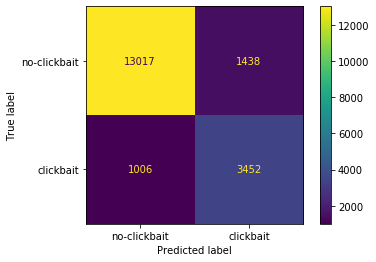

In [14]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

From the confusion matrix we can deduce that the classifier works quite well for both classes, although its ability to capture 'clickbait' tweets is lower when compared to the capacity of capturing 'no-clickbait' tweets. 

Next the precision and recall score are quite balanced, meaning that the classifier is considering both the correct classification for both classes and for clickbait tweets as well.

Both accuracy and f1 score are the best among all the tested architectures.

In [17]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8707767144292285
F1 Score:  0.7385537013264869
Precision Score:  0.7059304703476482
Recall Score:  0.7743382682817407


### Examples fo bad predictions

In [18]:
y_test = test_df.label.values
raw_predictions = model.predict({'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']},)
predictions_standard = np.where(raw_predictions > 0.5, 1, 0)

indexes = []
for index, (p1, y) in enumerate(zip(predictions_standard, y_test)):
    if p1 != y:
        #print(p1, y)
        indexes.append(index)
        
test_df['predictedClass'] = [x for x in predictions_standard]
wrong_predictions = test_df.iloc[indexes].sample(n=15)

for i, obs in enumerate(wrong_predictions.iterrows()):
    print('Tweet text: ',obs[1].postText)
    print('Original label: ', obs[1].truthClass)
    print('Predicted label: ', obs[1].predictedClass)
    print('\tRelated article: ',obs[1].targetTitle)
    print('\n')

Tweet text:  This 71-year-old grandpa rocks Supreme better than you.
Original label:  no-clickbait
Predicted label:  [1]
	Related article:  Meet The 71-Year-Old Grandpa Who Rocks Supreme Harder Than You


Tweet text:  How will each Power 5 conference team finish? 

Full projections:
Original label:  clickbait
Predicted label:  [0]
	Related article:  College Football 2017: Projecting the Record of Every Power 5 Conference Team


Tweet text:  If you’ve ever wondered what your dog is thinking … this smart collar will help
Original label:  no-clickbait
Predicted label:  [1]
	Related article:  If you’ve ever wondered what your dog is thinking … this smart collar will help


Tweet text:  “Come with me, your wife is here.” This moment seemed impossible to Mohammed Alqalos just 6 weeks ago.
Original label:  no-clickbait
Predicted label:  [1]
	Related article:  Caught Up in Travel Ban, a Family Reunites 


Tweet text:  Riding the wave: Meet the surfer who helped 7 million people get clean water

### Examples fo good predictions

In [19]:
y_test = test_df.label.values
predictions_standard = np.where(raw_predictions > 0.5, 1, 0)

indexes = []
for index, (p1, y) in enumerate(zip(predictions_standard, y_test)):
    if p1 == y:
        #print(p1, y)
        indexes.append(index)
        
test_df['predictedClass'] = [x for x in predictions_standard]
wrong_predictions = test_df.iloc[indexes].sample(n=15)

for i, obs in enumerate(wrong_predictions.iterrows()):
    print('Tweet text: ',obs[1].postText)
    print('Original label: ', obs[1].truthClass)
    print('Predicted label: ', obs[1].predictedClass)
    print('\tRelated article: ',obs[1].targetTitle)
    print('\n')

Tweet text:  You can now order Plan B on Seamless
Original label:  no-clickbait
Predicted label:  [0]
	Related article:  You Can Now Order Plan B On Seamless


Tweet text:  Opinion: Stop obsessing over "secrets" about Trump and Russia. What we already know is bad enough.
Original label:  no-clickbait
Predicted label:  [0]
	Related article:  Stop obsessing over ‘secrets’ about Trump and Russia. What we already know is bad enough.


Tweet text:  A Danish doctors association wants to end circumcision for boys, saying men should make the decision as adults
Original label:  no-clickbait
Predicted label:  [0]
	Related article:  Danish Doctors’ Group Wants to End Circumcision for Boys 


Tweet text:  Starbucks pledges to hire 10,000 refugees
Original label:  no-clickbait
Predicted label:  [0]
	Related article:  Starbucks pledges to hire 10,000 refugees


Tweet text:  Fury over India flag doormats for sale on Amazon
Original label:  no-clickbait
Predicted label:  [0]
	Related article:  Fury ov

# ROC curve

This sections analyses the ROC curve in order to see if a better threshold for the model predictions can be found and how models predictions changes consequently. 
The ROC curve consists in a graph that shows the performances of the classifier across several threshold values. This can provide a better understanding of how the model can be tuned, depending on how we want to favour actual clickbait detection rather than no-clickbait correct classification.

For that, we have to import the ground truth labels and the predictions first.

(array([0.        , 0.        , 0.        , ..., 0.98858526, 0.98872363,
       1.        ]), array([0.00000000e+00, 2.24315837e-04, 6.72947510e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00]), array([1.979873  , 0.97987294, 0.97976905, ..., 0.0045189 , 0.0045145 ,
       0.00303396], dtype=float32))


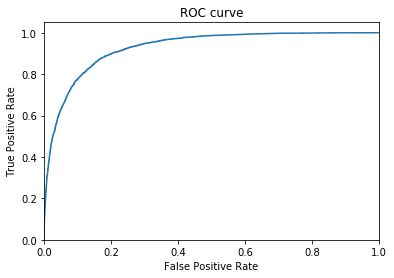

Best Threshold=0.289161


In [20]:
#raw_predictions = model.predict({'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']})
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, raw_predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

print(roc_curve(y_test, raw_predictions))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, raw_predictions)
# get the best threshold
diff = tpr - fpr
indexes = np.argmax(diff)
best_thresh = thresholds[indexes]
print('Best Threshold=%f' % (best_thresh))

In [21]:
score = roc_auc_score(y_test, predictions)
print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.8374


The ROC helps is a plot of the False Positive Rate (x-axis) versus the True Positive Rate (y-axis) for several threshold values (between (0,1)) and it helps to analyse how the efficiency of Binary Classifier.
The best threshold depends on the objective of the model application and it is important to establish if it is more important to have all positives classified as positive (in this case clickait tweets), even if it means misclassifying some non clickbait tweets as clickbaits. <br />

In this context, the ROC curve its quite good since it has a good balance between TPR and FPR, also known and sensitivity and specificity. The greater the area the better. 

In [22]:
predictions =np.where(raw_predictions > best_thresh, 1, 0)
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))


Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.96      0.83      0.89     14455
   clickbait       0.62      0.87      0.72      4458

    accuracy                           0.84     18913
   macro avg       0.79      0.85      0.81     18913
weighted avg       0.88      0.84      0.85     18913



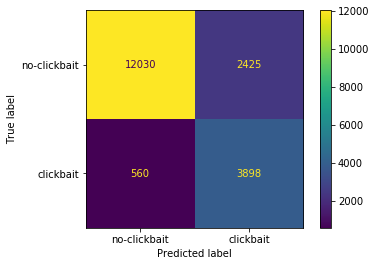

In [23]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [24]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8421720509702321
F1 Score:  0.7231240144699007
Precision Score:  0.6164795192155622
Recall Score:  0.8743831314490803


In [25]:
score = roc_auc_score(y_test, predictions)
print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.8533


By applying the new threshold the model do detect more clickbait tweets, but the general performances drop thus meaning that more no-clickbai

In the following part we will explore how predictions changes when adopting the new threshold suggest by the minimizationg of the difference between True Positive Rate and False Positive Rate. <br />
More precisely, some random examples are selected from: <br />
* tweets that are classified as 'clickbait' and are indeed 'clickbait' <br />
* tweets that are misclassified as 'clickbait' being 'no-clickbait' <br />

In [26]:
predictions_threshold =np.where(raw_predictions > best_thresh, 1, 0)
predictions_standard = np.where(raw_predictions > 0.5, 1, 0)


### Clickbait detected by new threshold

In [27]:
indexes = []
for index, (p1, p2, y) in enumerate(zip(predictions_standard,predictions_threshold, y_test)):
    if p1 != p2 and y == 1.0:
        #print(index, p1, p2, y)
        indexes.append(index)

test_df['predictedClass'] = [x for x in predictions_standard]
test_df['predictedClass_threshold'] = [x for x in predictions_threshold]
clickait_detected_by_threshold = test_df.iloc[indexes].sample(n=15)

for i, obs in enumerate(clickait_detected_by_threshold.iterrows()):
    print('Tweet text: ',obs[1].postText)
    print('Original label: ', obs[1].truthClass)
    print('Predicted label - 0.5: ', obs[1].predictedClass)
    print('Predicted label - '+str(best_thresh)[:4]+': ', obs[1].predictedClass_threshold)
    print('\tRelated article: ',obs[1].targetTitle)
    print('\n')
    

Tweet text:  Remembering the moments that turned Charlie Murphy into a comedy legend
Original label:  clickbait
Predicted label - 0.5:  [0]
Predicted label - 0.28:  [1]
	Related article:  The Moments That Turned Charlie Murphy Into a Comedy Legend


Tweet text:  Trump's tech policy remains a mystery
Original label:  clickbait
Predicted label - 0.5:  [0]
Predicted label - 0.28:  [1]
	Related article:  President Trump's tech policy is a mystery


Tweet text:  Lab notes: throw your hands in the air like you just don't care
Original label:  clickbait
Predicted label - 0.5:  [0]
Predicted label - 0.28:  [1]
	Related article:  Lab notes: throw your hands in the air like you just don't care


Tweet text:  Puff, puff, pass: @WizKhalifa's highest lyrics
Original label:  clickbait
Predicted label - 0.5:  [0]
Predicted label - 0.28:  [1]
	Related article:  Puff, Puff, Pass: Wiz Khalifa's Highest Lyrics


Tweet text:  The best employer in Canada is an institution older than the country itself. See

### No-Clickbait misclassified by new threshold

In [28]:
indexes = []
for index, (p1, p2, y) in enumerate(zip(predictions_standard,predictions_threshold, y_test)):
    if p1 != p2 and y == 0.0:
        #print(index, p1, p2, y)
        indexes.append(index)
    
clickait_detected_by_threshold = test_df.iloc[indexes].sample(n=15)
for i, obs in enumerate(clickait_detected_by_threshold.iterrows()):
    print('Tweet text: ',obs[1].postText)
    print('Original label: ', obs[1].truthClass)
    print('Predicted label - 0.5: ', obs[1].predictedClass)
    print('Predicted label - '+str(best_thresh)[:4]+': ', obs[1].predictedClass_threshold)
    print('\tRelated article: ',obs[1].targetTitle)
    print('\n')
    


Tweet text:  New year, new architecture: 2017's most anticipated building openings
Original label:  no-clickbait
Predicted label - 0.5:  [0]
Predicted label - 0.28:  [1]
	Related article:  New year, new buildings: 2017's most anticipated openings


Tweet text:  High school kid becomes viral sensation after refusing to run from hail storm
Original label:  no-clickbait
Predicted label - 0.5:  [0]
Predicted label - 0.28:  [1]
	Related article:  High school kid becomes viral sensation after refusing to run from hail storm


Tweet text:  The moment Russian model Viktoria Odintsova risks her life in daredevil Dubai photoshoot
Original label:  no-clickbait
Predicted label - 0.5:  [0]
Predicted label - 0.28:  [1]
	Related article:  The moment Russian model Viki Odintcova risks her life in daredevil Dubai photoshoot


Tweet text:  Appease or oppose? How the world's nations are reacting to Trump
Original label:  no-clickbait
Predicted label - 0.5:  [0]
Predicted label - 0.28:  [1]
	Related artic